# Plots of experiments

***

**Import libraries:**

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import os
import datetime
import copy

dev = 'cuda'
meas = 'energy_consumed'
comp = 'linux_alienware'
ml = 'training'

**Usefull functions and variables:**

In [2]:
def def_fig_title(exp):
    if exp == 'SQUAD-v1-1':
        fig_title = 'Fine-tuning Bert-base on SQUAD'
    elif exp == 'cifar10':
        fig_title = 'Training on CIFAR10'
    elif exp == 'mnist':
        fig_title = 'Training on MNIST'
    elif exp == 'idle':
        fig_title = 'Idle during 10 minutes'
    else:
        fig_title = 'Training on ImageNet'
    return fig_title

def def_fig_y_axis(exp):
    if exp == 'idle':
        y_label = 'energy consumed (Wh)'
    else:
        y_label = 'energy consumed per epoch (Wh)'
    return y_label

tr = {'energy_consumed':'Energy cons. (kWh)',\
    'co2_emissions': 'CO2 equiv. (kg)',\
    'time':'Duration (s)',\
    'cifar10' : 'CIFAR10',\
    'mnist' : 'MNIST',\
    'SQUAD-v1-1' : 'SQUAD',\
    'image_net' : 'ImageNet',\
    'time_error': 'Duration error (s)'
    }

def func_calc_short(calc):
    if calc == 'GA:auto-para':
        temp = 'GA:auto'.split(':')
        return '\n'.join(temp)
    elif calc == 'FLOPS':
        return 'Flops'
    elif calc == 'CC:on':
        return 'CC'
    elif calc == 'ECO2AI':
        return 'Eco2AI'
    elif calc == 'TAPO':
        return 'EPM'
    elif calc == 'TAPO:dyn':
        return 'EPM\ndyn'
    elif calc == 'TAPO:tot':
        return 'EPM\ntot'
    else:
        temp = calc.split(':')
        return '\n'.join(temp)

def create_calc_labels(calc_list):
    calc_list_label = []
    for calc in calc_list:
        calc_list_label.append(func_calc_short(calc))
    return calc_list_label

**Function to load the experiments results into a dataFrame:**

This function will be used to make the error bar plot.

The results data is initially contained in a json file, that we first load in the dictionnary ``d``. A list of ``n_iter`` values is found at: ``d[exp_key][ml_key][comp_key][dev_key][calc_key][meas_key]``.

In [3]:
def load_exp_results(file_name):
    """Loads results of the experiments qnd transform them for the error bar plot:
    - remove idle pozer from tapo
    - converto to a per epoch value"""

    # power_idle = 69 # Watts
    reform = []
    with open(file_name, 'r') as file:
        d = json.load(file)
        for exp_key, exp_dict in d.items(): 
            for ml_key, ml_dict in exp_dict.items():
                for comp_key, comp_dict in ml_dict.items():
                    for dev_key, dev_dict in comp_dict.items():
                        for calc_key, calc_dict in dev_dict.items():
                    
                            for meas_key, value in calc_dict.items():
                                
                                if value != [] and 'N/A' not in value:

                                    val_array = np.array(value)
                                    
                                    # Special case of the energy:
                                    if meas_key == 'energy_consumed':

                                        # Converting to Wh (instead of kWh):
                                        val_array = val_array*10**3
                                        
                                        if  calc_key == 'TAPO':
                                            # removing the idle energy consumed:
                                            duration = np.array(calc_dict['time'])
                                            # val_array = val_array - duration*power_idle/(3.6*10**3) # in Wh
                                            val_array = val_array

                                    # Converting all data to a "per epoch" value:
                                    nb_epochs = calc_dict['epochs'][0]
                                    val_array = val_array/nb_epochs
                                    
                                    mean_val = val_array.mean()
                                    min_val = val_array.min()
                                    max_val = val_array.max()
                                    std_val = val_array.std()
                                    nb_val = val_array.size

                                    if nb_val == 1:
                                        unbiased_std_val = 0
                                    else:
                                        unbiased_std_val = np.sqrt(1/(nb_val-1)*np.sum(np.sum(np.square(val_array - mean_val))))
                                        
                                    reform.append((exp_key, ml_key, comp_key, dev_key, calc_key, 
                                                    meas_key, mean_val, min_val, max_val, std_val, unbiased_std_val, nb_val))
                                    
    dat_all = pd.DataFrame(reform, columns = ['exp', 'ml', 'comp', 'dev', 'calc',
                                        'meas', 'mean_val', 'min_val', 'max_val', 'std_val', 'unbiased_std_val', 'nb_val'])


    return dat_all

**Function for plotting error bar:**

In [4]:
def plot_one_error_bar(x, mean, min_val, max_val, color='#2187bb', horizontal_line_width=0.5):
    color = 'k'
    left = x - horizontal_line_width / 2
    bottom = min_val
    right = x + horizontal_line_width / 2
    top = max_val
    plt.plot([x, x], [top, bottom], color=color)
    plt.plot([left, right], [top, top], color=color)
    plt.plot([left, right], [bottom, bottom], color=color)
    plt.plot(x, mean, 'o', color='#f44336')

def plot_all_error_bar(folder, file_name, name, exp, meas_calc_list, to_save):

    dat_all = load_exp_results(os.path.join(folder, file_name))

    select = (dat_all['exp'] == exp) & (dat_all['comp'] == comp) & (dat_all['dev'] == dev) \
        & (dat_all['meas'] == meas) & (dat_all['ml'] == ml)
    dat = dat_all[select]

    calc_list = meas_calc_list[meas]
    calc_list_label = create_calc_labels(calc_list)

    FS = 14
    matplotlib.rc('xtick', labelsize=FS-2) 
    matplotlib.rc('ytick', labelsize=FS-2)

    plt.figure(figsize=(6.5, 4.5))
    plt.xticks([i+1 for i in range(len(calc_list))], calc_list_label)

    for kk in range(len(calc_list)):
        dat_calc = dat[dat['calc'] == calc_list[kk]]
        mean = dat_calc['mean_val'].values[0]
        min_val = dat_calc['min_val'].values[0]
        max_val = dat_calc['max_val'].values[0]
        plot_one_error_bar(kk+1, mean, min_val, max_val)

    plt.grid(alpha = 1, linestyle = '--')
    fig_title = def_fig_title(exp)
    plt.title(fig_title, fontsize = FS +2)
    plt.xlabel('estimation method or tool', fontsize = FS)
    plt.ylabel(def_fig_y_axis(exp), fontsize = FS)

    if to_save:
        plt.savefig(os.path.join(folder, name + '_energy' + '.pdf'), bbox_inches='tight') 
    plt.show()

**Function for plotting evolution:**

In [5]:
def plot_evolution(folder, file_name, name, exp, meas_calc_list, to_save):

    with open(os.path.join(folder, file_name), 'r') as f:
        d = json.load(f)
        
    # fig = plt.figure(figsize=(4,3.75))
    fig = plt.figure(figsize=(5.5, 6.5))

    calc_list = meas_calc_list[meas]
    calc_list_label = create_calc_labels(calc_list)

    nb_iter = len(d[exp][ml][comp][dev][calc_list[0]][meas])
    iter_list = [ii + 1 for ii in range(nb_iter)]

    d_select = d[exp][ml][comp][dev]

    for k in range(len(calc_list)):
        calc = calc_list[k]
        calc_label = calc_list_label[k]

        if calc == 'FLOPS' and len(d_select[calc][meas]) == 1:
            meas_list = np.array(d_select[calc][meas]*nb_iter)
        else:
            meas_list = np.array(d_select[calc][meas])

        plt.plot(iter_list, meas_list, label = calc_label, marker = 'o')

    FS = 14
    plt.xticks(iter_list, fontsize = FS)
    ax = fig.gca(); 
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.ticklabel_format(style = 'sci')
    plt.grid(alpha = 1, linestyle = '--')
    plt.legend(loc='best', fontsize = FS-2)
    fig_title = def_fig_title(exp)
    plt.title(fig_title, fontsize = FS+2)
    plt.xlabel('Iteration of the experiment', fontsize = FS)
    plt.ylabel('Energy consumed per epoch (Wh)', fontsize = FS)

    if to_save:
        plt.savefig(os.path.join(folder, name + '_evolution' + '.pdf'), bbox_inches='tight')
        
    plt.show()

In [6]:
def extract_power(folder, file_name, meas_calc_list):
    calc_list = meas_calc_list['energy_consumed']
    with open(os.path.join(folder, file_name), 'r') as file:
        d = json.load(file)
    res = d['idle']['training']['linux_alienware']['cuda']
    res['power'] = {}
    for calc in calc_list:
        pow = [nrj*1000/(t/3600) for nrj, t in zip(res[calc]['energy_consumed'], res[calc]['time'])]
        res['power'][calc] = np.array(pow).mean()
    return(res['power'])

## 5. Final Paper

{'CT:pred': 28.314770918284268, 'CT:meas': 28.065697815160128, 'CC:on': 52.498491203947104, 'ECO2AI': 24.90006301980474, 'GA:auto-para': 1.5441070978264082, 'TAPO': 66.45618748873903}


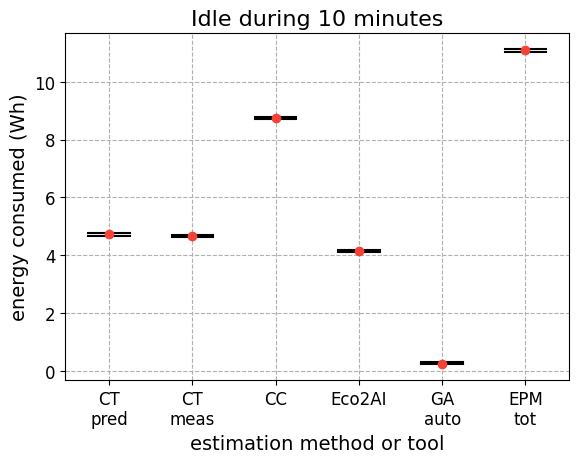

In [7]:
folder='survey'
do_save=False

# IDLE TMP

meas_calc_list = {
    'time' : ['CT:pred', 'CT:meas', 'CC:on', 'ECO2AI', 'GA:auto-para', 'TAPO'],
    'energy_consumed' :  ['CT:pred', 'CT:meas', 'CC:on', 'ECO2AI', 'GA:auto-para', 'TAPO'],
    'co2_emissions' : ['CT:pred', 'CT:meas', 'CC:on', 'ECO2AI', 'GA:auto-para']
}

exp = 'idle'
file_name = 'res-sophIA-idle.json'
name = 'idle'

with open(os.path.join(folder, file_name), 'r') as file:
    d = json.load(file)
d[exp]['training']['linux_alienware']['cuda']['TAPO:tot'] = copy.deepcopy(d[exp]['training']['linux_alienware']['cuda']['TAPO'])
new_file_name = 'res-sophIA-idle-tmp.json'
with open(os.path.join(folder, new_file_name), 'w') as file:
    json.dump(d, file, indent = 4, sort_keys=True)

# five time 10 minutes experiments, with 2 minutes breaks
# computer not in sleep mode, but done doing any computing task

idle_power = extract_power(folder, new_file_name, meas_calc_list)
print(idle_power)

meas_calc_list = {
    'time' : ['CT:pred', 'CT:meas', 'CC:on', 'ECO2AI', 'GA:auto-para', 'TAPO:tot'],
    'energy_consumed' :  ['CT:pred', 'CT:meas', 'CC:on', 'ECO2AI', 'GA:auto-para', 'TAPO:tot'],
    'co2_emissions' : ['CT:pred', 'CT:meas', 'CC:on', 'ECO2AI', 'GA:auto-para']
}

plot_all_error_bar(folder, new_file_name, name, exp, meas_calc_list, to_save=do_save)
# plot_evolution(folder, file_name, name, exp, meas_calc_list, to_save=do_save)

In [8]:
def total_to_dynamic_EPM(exp, folder, file_name, new_file_name, meas_calc_list, idle_power):
    with open(os.path.join(folder, file_name), 'r') as file:
        d = json.load(file)
    
    calc = 'TAPO'
    times = d[exp]['training']['linux_alienware']['cuda'][calc]['time']
    nrjs = d[exp]['training']['linux_alienware']['cuda'][calc]['energy_consumed']
    dyn_nrjs = [nrj - t/3600*idle_power[calc]/1000 for t, nrj in zip(times, nrjs)]

    d[exp]['training']['linux_alienware']['cuda']['TAPO:tot'] = copy.deepcopy(d[exp]['training']['linux_alienware']['cuda']['TAPO'])
    d[exp]['training']['linux_alienware']['cuda']['TAPO:dyn'] = copy.deepcopy(d[exp]['training']['linux_alienware']['cuda']['TAPO'])

    d[exp]['training']['linux_alienware']['cuda']['TAPO:tot']['energy_consumed'] = nrjs
    d[exp]['training']['linux_alienware']['cuda']['TAPO:dyn']['energy_consumed'] = dyn_nrjs

    # dev meas comp ml
    with open(os.path.join(folder, new_file_name), 'w') as file:
        json.dump(d, file, indent = 4, sort_keys=True)

meas_calc_list = {
    'time' : ['CT:pred', 'CT:meas', 'CC:on', 'ECO2AI', 'GA:def', 'GA:auto-para', 'TAPO'],
    'energy_consumed' :  ['CT:pred', 'CT:meas', 'CC:on', 'ECO2AI', 'GA:def', 'GA:auto-para', 'FLOPS', 'TAPO'],
    'co2_emissions' : ['CT:pred', 'CT:meas', 'CC:on', 'ECO2AI', 'GA:def', 'GA:auto-para']
}
meas_calc_list_2 = {
    'time' : ['CT:pred', 'CT:meas', 'CC:on', 'ECO2AI', 'GA:def', 'GA:auto-para', 'TAPO:dyn', 'TAPO:tot'],
    'energy_consumed' :  ['CT:pred', 'CT:meas', 'CC:on', 'ECO2AI', 'GA:def', 'GA:auto-para', 'FLOPS', 'TAPO:dyn', 'TAPO:tot'],
    'co2_emissions' : ['CT:pred', 'CT:meas', 'CC:on', 'ECO2AI', 'GA:def', 'GA:auto-para']
}

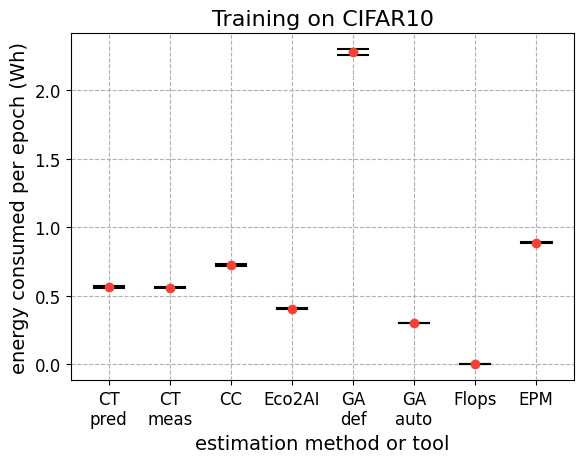

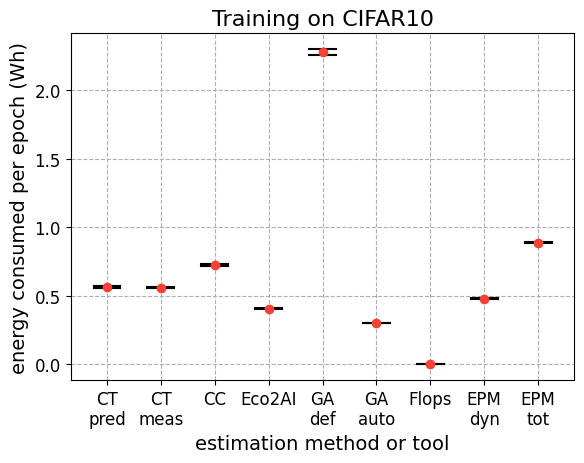

In [9]:
exp='cifar10'
file_name = 'res-sophIA-cifar10.json'
name = 'cifar10'
plot_all_error_bar(folder, file_name, name, exp, meas_calc_list, to_save=do_save)
# plot_evolution(folder, file_name, name, exp, meas_calc_list, to_save=do_save)

new_file_name = 'res-sophIA-cifar10_dyn-EPM.json'
total_to_dynamic_EPM(exp,folder, file_name, new_file_name, meas_calc_list, idle_power)
plot_all_error_bar(folder, new_file_name, name+'_dyn-EPM', exp, meas_calc_list_2, to_save=do_save)

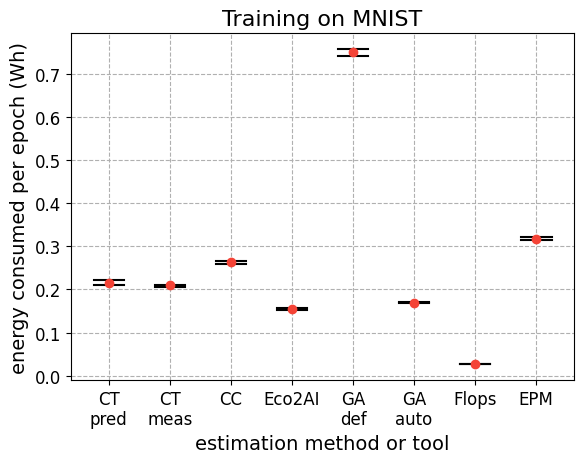

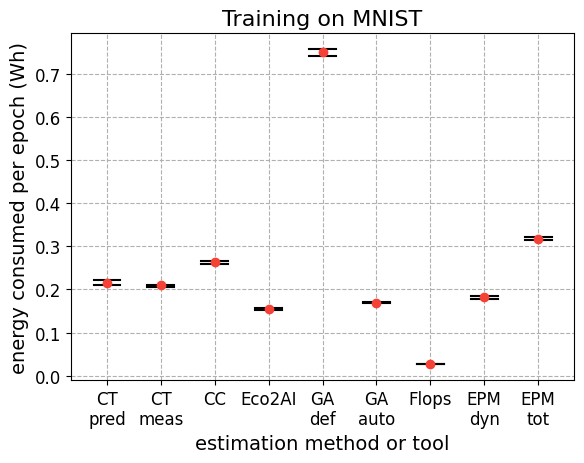

In [10]:
exp='mnist'
file_name = 'res-sophIA-mnist.json'
name = 'mnist'
plot_all_error_bar(folder, file_name, name, exp, meas_calc_list, to_save=do_save)
# plot_evolution(folder, file_name, name, exp, meas_calc_list, to_save=do_save)

new_file_name = 'res-sophIA-mnist_dyn-EPM.json'
total_to_dynamic_EPM(exp,folder, file_name, new_file_name, meas_calc_list, idle_power)
plot_all_error_bar(folder, new_file_name, name+'_dyn-EPM', exp, meas_calc_list_2, to_save=do_save)

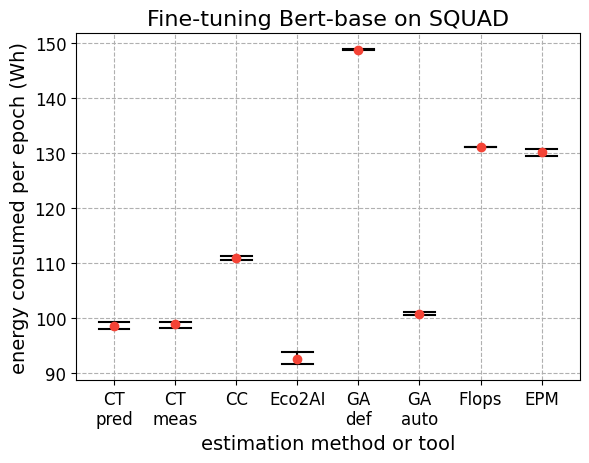

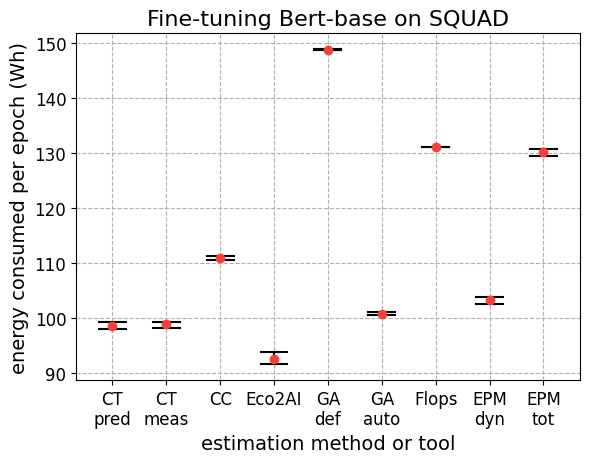

In [11]:
exp='SQUAD-v1-1'
file_name = 'res-sophIA-squad3.json'
name = 'SQUAD-v1-1'
plot_all_error_bar(folder, file_name, name, exp, meas_calc_list, to_save=do_save)
# plot_evolution(folder, file_name, name, exp, meas_calc_list, to_save=do_save)

new_file_name = 'res-sophIA-squad3_dyn-EPM.json'
total_to_dynamic_EPM(exp,folder, file_name, new_file_name, meas_calc_list, idle_power)
plot_all_error_bar(folder, new_file_name, name+'_dyn-EPM', exp, meas_calc_list_2, to_save=do_save)

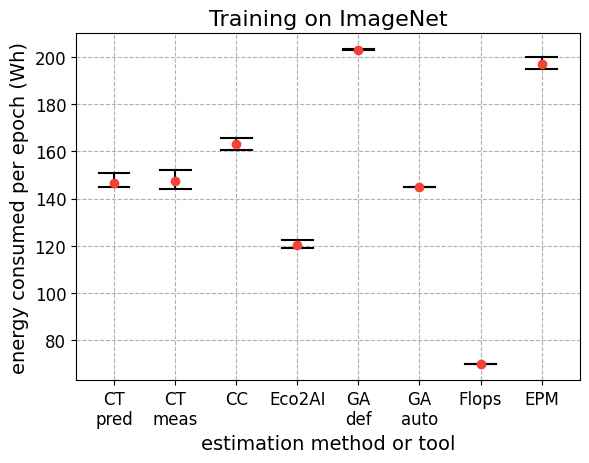

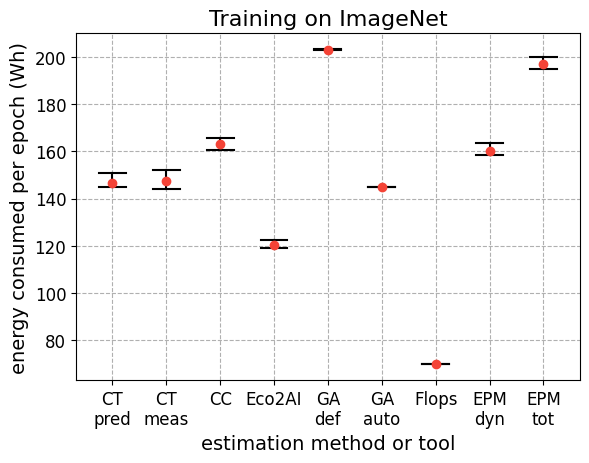

In [12]:
exp='image_net'
file_name = 'res-sophIA-resnet.json'
name = 'image_net'
plot_all_error_bar(folder, file_name, name, exp, meas_calc_list, to_save=do_save)
# plot_evolution(folder, file_name, name, exp, meas_calc_list, to_save=do_save)

new_file_name = 'res-sophIA-resnet_dyn-EPM.json'
total_to_dynamic_EPM(exp,folder, file_name, new_file_name, meas_calc_list, idle_power)
plot_all_error_bar(folder, new_file_name, name+'_dyn-EPM', exp, meas_calc_list_2, to_save=do_save)